In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()

'D:\\GitHub\\Backtesting'

In [3]:
dta = pd.read_csv("broader_stock.csv")

In [4]:
def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    # NHLI not traded
    dta.drop(['Date', 'NHLI'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    for tick in dta.columns:
        dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

    return dta[dta.index >= dta['SPY'].first_valid_index()]

In [5]:
dta = data_preprocess(dta)
pct_dta = dta.pct_change()

In [6]:
t = "TSLA"

temp_dta = pct_dta[pct_dta[t].notnull()]
temp_dta['%s_LAG' % t] = temp_dta['%s' % t].shift(-1)
temp_dta.dropna(inplace=True)

C:\Users\Andyy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Andyy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
cointegrat = {}
correlat = {}

for col in temp_dta.columns[:-1]:
    x = temp_dta[col]
    score, pval, _ = sm.tsa.coint(x, temp_dta['%s_LAG' % t], autolag='bic')
    corr = abs(x.corr(temp_dta['%s_LAG' % t]))
    cointegrat[col] = pval
    correlat[col] = corr

best_coint = sorted(cointegrat, key=cointegrat.get)[:50]
best_corr = sorted(correlat, key=correlat.get, reverse=True)[:50]
union_X = list(set(best_coint) | set(best_corr))

In [17]:
lag_1_res = pd.read_csv("XGB_Pred_1.csv")


In [85]:
list(set(lag_1_res['Unnamed: 0'][:10]) | set(['TQQQ', 'UVXY']))

['NVDA', 'SEDG', 'TQQQ', 'UVXY', 'TSLA', 'AMD']

In [102]:
lag_1_res[lag_1_res['Unnamed: 0'] == 'TQQQ'].sort_values('sharpe', ascending=False)['Unnamed: 1'].iloc[0]

1

In [8]:
X = temp_dta[best_corr].values
y = temp_dta['%s_LAG' % t].values
y = (y > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42,
                                                    stratify=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth': 2,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.443279
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.480164
[2]	Test-auc:0.513934
[3]	Test-auc:0.459672
[4]	Test-auc:0.450656
[5]	Test-auc:0.470164
[6]	Test-auc:0.422623
[7]	Test-auc:0.395082
[8]	Test-auc:0.398852
[9]	Test-auc:0.437541
[10]	Test-auc:0.413607
[11]	Test-auc:0.407705
[12]	Test-auc:0.446721
Stopping. Best iteration:
[2]	Test-auc:0.513934



In [10]:
y_pred = model.predict(dtest)


In [12]:
y_pred = (y_pred > 0.5).astype(int)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.4864864864864865

# Time Series

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [24]:
y = temp_dta['%s_LAG' % t].values
y_train = y[:int(y.shape[0] * 0.8)]
y_test = y[int(y.shape[0] * 0.8):]

In [48]:
mod = AutoReg(y_train, lags=10).fit('HC3')

In [58]:
y_pred = mod.predict()[:111]

In [70]:
bi_pred = (y_pred > 0).astype(int)
bi_test = (y_test > 0).astype(int)

In [73]:
accuracy_score(bi_pred, bi_test)

0.5855855855855856

In [30]:
ttl_test = pct_dta[pct_dta.index >= temp_dta.index[0]]

In [56]:
ttl_test

,AME,NOW,XYL,BAC,TGI,AMBC,NSP,MOS,MEI,PSB,...,LNN,TDY,BBBY,K,BEN,THRM,PAYX,TSLA,BABA,NIO
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-30,0.010362,0.026000,-0.008618,0.006349,0.047004,0.008837,0.018246,0.027251,0.029179,0.010080,...,0.031115,-0.000233,0.051834,0.022253,0.045759,0.014770,0.011096,-0.014783,0.022117,-0.038772
2018-10-31,0.010562,0.074421,0.010115,0.026814,0.012346,0.001460,0.013415,0.016454,0.005600,-0.015612,...,-0.003651,0.029688,-0.044731,-0.088738,-0.015653,-0.007505,0.022281,0.022431,0.043644,-0.008403
2018-11-01,0.067707,0.014859,0.048349,0.011137,0.081486,0.009232,0.012765,0.038322,0.021232,0.007276,...,0.062190,0.026482,0.033333,-0.022561,0.016625,0.006416,-0.007645,0.020753,0.063045,0.122034
2018-11-02,0.014045,-0.026942,-0.010597,0.003038,0.012814,0.003370,-0.000560,-0.006682,0.001704,0.000730,...,0.010452,-0.000352,0.036098,-0.015784,-0.009954,0.006375,0.007704,0.006099,-0.024198,-0.019637
2018-11-05,0.012031,0.009117,0.007241,0.006058,0.000506,0.002879,-0.003456,0.009609,0.000000,0.013625,...,0.009540,-0.002334,-0.030393,0.002414,0.003950,-0.016516,0.012036,-0.014434,-0.019988,0.029276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,0.009263,0.005572,0.010022,0.011007,-0.006329,0.011842,0.000737,0.038357,0.000261,0.007889,...,0.012134,0.002250,-0.047721,0.011377,0.008475,0.010536,0.011287,0.015674,-0.023743,0.007441
2021-01-04,-0.021168,-0.042876,-0.020631,-0.009238,-0.065287,-0.036411,-0.029477,0.028683,-0.018025,-0.024084,...,-0.007707,-0.075489,0.015203,-0.012534,-0.026010,-0.026986,-0.030264,0.034152,-0.020969,0.097456
2021-01-05,0.006927,0.009756,-0.001204,0.007659,0.097104,0.034413,0.016958,0.037178,0.012503,0.000771,...,0.020240,0.036149,0.095951,0.005696,-0.002465,0.031516,-0.003763,0.007317,0.055080,-0.005422


In [73]:
final_val = xgb.DMatrix(pct_dta.iloc[-1][best_corr], label=[0])

In [74]:
model.predict(final_val)

array([0.67870736], dtype=float32)

In [31]:
ttl_test_x = ttl_test[best_corr].values
ttl_matrix = xgb.DMatrix(ttl_test_x, label=np.zeros(ttl_test_x.shape[0]))

In [64]:
ttl_pred = model.predict(ttl_matrix)


In [67]:
ttl_pred[-1]

0.48533434

In [58]:
ttl_pred = (ttl_pred > 0.5).astype(int)
ttl_pred.shape

(551,)

In [48]:
inventory = 0
asset = 0
record = [asset]

for i, dt in enumerate(ttl_test.index):
    price = dta.loc[dt]['TSLA']
    trend_good = ttl_pred[i] == 1
    if trend_good and inventory == 0 and i != len(ttl_pred) - 1:
        # buy
        asset -= price
        inventory += 1
    elif not trend_good and inventory == 1:
        # sell
        asset += price
        inventory -= 1
    elif i == len(ttl_pred) - 1 and inventory == 1:
        # liquidate in the end
        asset += price
        inventory -= 1
    else:
        asset = record[-1]
    record.append(asset)

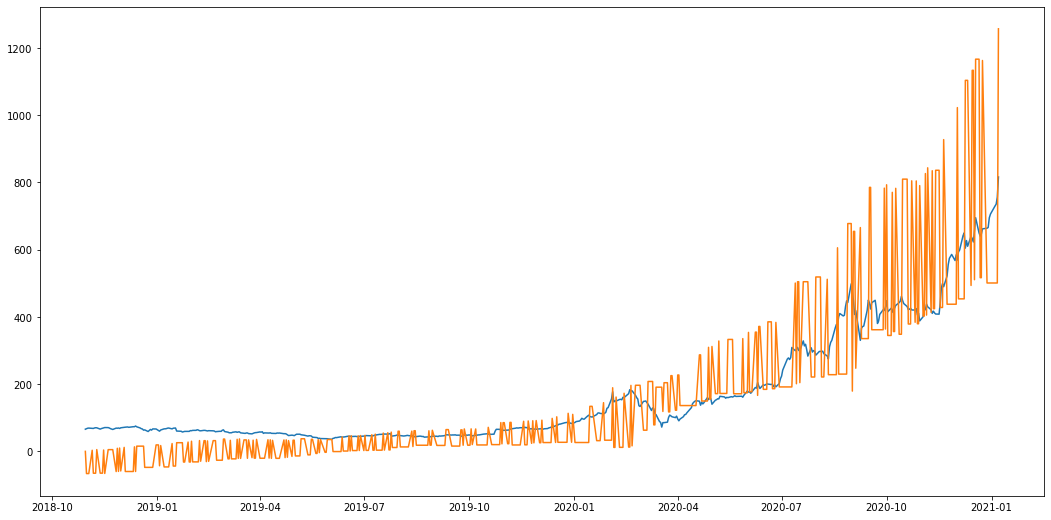

In [54]:
plt.figure(figsize=(18,9))
plt.plot(dta[dta.index >= temp_dta.index[0]].index, dta[dta.index >= temp_dta.index[0]]['TSLA'])
plt.plot(dta[dta.index >= temp_dta.index[0]].index, record[:-1])